In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xgboost as xgb
from sklearn.metrics import confusion_matrix, adjusted_rand_score, roc_curve, auc, classification_report, f1_score, cohen_kappa_score
import plotly.graph_objects as go
from itertools import cycle, islice
from sklearn.preprocessing import label_binarize

import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=100, dpi_save=200)

In [ ]:
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [ ]:
#Loading in the corresponding h5ad files
P8_adata = sc.read_h5ad('P8_non_analyzed.h5ad')
P14_adata = sc.read_h5ad('P14_non_analyzed.h5ad')
P17_adata = sc.read_h5ad('P17_non_analyzed.h5ad')
P21_adata = sc.read_h5ad('P21_non_analyzed.h5ad')
P28_adata = sc.read_h5ad('P28_non_analyzed.h5ad')
P38_adata = sc.read_h5ad('P38_non_analyzed.h5ad')

In [ ]:
#Defining class that contains functions that will perform the mapping with XGBoost and plot the results
class TimeMapping():
    
    # xgbclassifier will run the feature selection, training and validation, and testing
    def xgbclassifier(
        self,
        train_anndata,
        test_anndata,
        train_dict,
        test_dict,
        max_cells_per_ident = 700,
        train_frac = 0.7
        ): 

        self.train_dict = train_dict
        self.test_dict = test_dict

        self.numbertrainclasses = len(train_anndata.obs.Type.values.categories)
        self.numbertestclasses = len(test_anndata.obs.Type.values.categories)

        #Splitting the cell barcodes into a training set and validation set based on the minimum of 70% of cells or 700 cells
        #Creating array of the labels for each cell (the leiden each cell barcode belongs too)
        training_set_train = []
        training_label_train = []

        for i in train_anndata.obs.Type.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train = np.hstack([training_set_train,train_temp])
            training_label_train = np.hstack([training_label_train,np.repeat(train_dict[i],len(train_temp))])

        training_set_test = []
        training_label_test = []

        for i in test_anndata.obs.Type.values.categories.values:
            cells_in_clust = test_anndata.obs.index[test_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_test = np.hstack([training_set_test,train_temp])
            training_label_test = np.hstack([training_label_test,np.repeat(test_dict[i],len(train_temp))])

        train_index_train = []
        for i in training_set_train:
            train_index_train.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_index_test = []
        for i in training_set_test:
            train_index_test.append(np.where(test_anndata.obs.index.values == i)[0][0])

        train_matrix_train = xgb.DMatrix(data = train_anndata.raw.X.A[train_index_train,:], label = training_label_train, feature_names = train_anndata.var.index.values)

        train_matrix_test = xgb.DMatrix(data = test_anndata.raw.X.A[train_index_test,:], label = training_label_test, feature_names = test_anndata.var.index.values)

        del training_set_train, training_label_train, training_set_test, training_label_test, train_index_train, train_index_test

        #Defining parameters for the XGBoost Model
        xgb_params_train = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertrainclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the training data
        bst_model_train = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train,
            num_boost_round = nround)

        xgb_params_test = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertestclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the testing data
        bst_model_test = xgb.train(
            params = xgb_params_test,
            dtrain = train_matrix_test,
            num_boost_round = nround)

        train_xgboost_scores = bst_model_train.get_score(importance_type="gain")
        sort_train_scores = {k: v for k, v in sorted(train_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestrain = list(sort_train_scores.keys())

        test_xgboost_scores = bst_model_test.get_score(importance_type="gain")
        sort_test_scores = {k: v for k, v in sorted(test_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestest = list(sort_test_scores.keys())

        common_top_genes = np.array([i for i in top500genestrain if i in top500genestest]) #These are the features that we will use for training, validating and testing

        del train_matrix_train, train_matrix_test, bst_model_train, bst_model_test, train_xgboost_scores, sort_train_scores, top500genestrain, test_xgboost_scores, sort_test_scores, top500genestest

        #Train XGBoost on 70% of training data and validate on the remaining data
        common_top_genes_index_train = []
        for i in common_top_genes:
            common_top_genes_index_train.append(np.where(train_anndata.var.index.values == i)[0][0])

        training_set_train_70 = []
        validation_set_train_70 = []
        training_label_train_70 = []
        validation_label_train_70 = []

        for i in train_anndata.obs.Type.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            validation_temp = np.setdiff1d(cells_in_clust, train_temp)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_70 = np.hstack([training_set_train_70,train_temp])
            validation_set_train_70 = np.hstack([validation_set_train_70,validation_temp])
            training_label_train_70 = np.hstack([training_label_train_70,np.repeat(train_dict[i],len(train_temp))])
            validation_label_train_70 = np.hstack([validation_label_train_70,np.repeat(train_dict[i],len(validation_temp))])

        train_index_train_70 = []
        for i in training_set_train_70:
            train_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])
        validation_index_train_70 = []
        for i in validation_set_train_70:
            validation_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][train_index_train_70,:], label = training_label_train_70)
        validation_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][validation_index_train_70,:], label = validation_label_train_70)

        del training_set_train_70, validation_set_train_70, training_label_train_70, train_index_train_70, validation_index_train_70

        bst_model_train_70 = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train_70,
            num_boost_round = nround)

        validation_pred_train_70 = bst_model_train_70.predict(data = validation_matrix_train_70)

        valid_predlabels_train_70 = np.zeros((validation_pred_train_70.shape[0]))
        for i in range(validation_pred_train_70.shape[0]):
            valid_predlabels_train_70[i] = np.argmax(validation_pred_train_70[i,:])
        
        f1 = f1_score(validation_label_train_70, valid_predlabels_train_70, average = None)
        
        del train_matrix_train_70, validation_matrix_train_70, validation_pred_train_70

        #Train XGBoost on the full training data
        training_set_train_full = []
        training_label_train_full = []

        for i in train_anndata.obs.Type.values.categories.values:
            train_temp = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_full = np.hstack([training_set_train_full,train_temp])
            training_label_train_full = np.hstack([training_label_train_full,np.repeat(train_dict[i],len(train_temp))])

        train_index_full = []
        for i in training_set_train_full:
            train_index_full.append(np.where(train_anndata.obs.index.values == i)[0][0])

        full_training_data = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][train_index_full,:], label = training_label_train_full)

        del common_top_genes_index_train, training_set_train_full, training_label_train_full, train_index_full

        bst_model_full_train = xgb.train(
            params = xgb_params_train,
            dtrain = full_training_data,
            num_boost_round = nround)

        #Predict the testing leiden labels
        common_top_genes_index_test = []
        for i in common_top_genes:
            common_top_genes_index_test.append(np.where(test_anndata.var.index.values == i)[0][0])

        full_testing_data = xgb.DMatrix(data = test_anndata.raw.X.A[:,common_top_genes_index_test])
        test_prediction = bst_model_full_train.predict(data = full_testing_data)

        del bst_model_full_train, full_testing_data

        test_predlabels = np.zeros((test_prediction.shape[0]))
        for i in range(test_prediction.shape[0]):
            if np.max(test_prediction[i,:]) > 1.1*(1/self.numbertrainclasses):
                test_predlabels[i] = np.argmax(test_prediction[i,:])
            else:
                test_predlabels[i] = self.numbertrainclasses

        test_labels = np.zeros(len(test_anndata.obs.Type.values))
        for i,l in enumerate(test_anndata.obs.Type.values):
            test_labels[i] = test_dict[l]

        return validation_label_train_70, valid_predlabels_train_70, test_labels, test_predlabels

    #plotConfusionMatrix will take the results from the xgboost classifier and plot them
    def plotConfusionMatrix(
        self,
        ytrue,
        ypred,
        type,
        save_as,
        title = '',
        xaxislabel = '',
        yaxislabel = ''
        ):

        confusionmatrix = confusion_matrix(y_true = ytrue, y_pred = ypred)
        if type == 'mapping':
          if self.numbertrainclasses in ypred:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses+1]
          else:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses]
        confmatpercent = np.zeros(confusionmatrix.shape)
        for i in range(confusionmatrix.shape[0]):
          if np.sum(confusionmatrix[i,:]) != 0:
            confmatpercent[i,:] = confusionmatrix[i,:]/np.sum(confusionmatrix[i,:])
          else:
            confmatpercent[i,:] = confusionmatrix[i,:]
        diagcm = confmatpercent
        xticks = np.linspace(0, confmatpercent.shape[1]-1, confmatpercent.shape[1], dtype = int)
        xticksactual = []
        for i in xticks:
          if i != self.numbertrainclasses:
            xticksactual.append(list(self.train_dict.keys())[i])
          else:
            xticksactual.append('Unassigned')
        dot_max = np.max(diagcm.flatten())
        dot_min = 0
        if dot_min != 0 or dot_max != 1:
            frac = np.clip(diagcm, dot_min, dot_max)
            old_range = dot_max - dot_min
            frac = (frac - dot_min) / old_range
        else:
            frac = diagcm
        xvalues = []
        yvalues = []
        sizes = []
        for i in range(diagcm.shape[0]):
            for j in range(diagcm.shape[1]):
                xvalues.append(j)
                yvalues.append(i)
                sizes.append((frac[i,j]*35)**1.5)
        size_legend_width = 0.5
        height = diagcm.shape[0] * 0.3 + 1
        height = max([1.5, height])
        heatmap_width = diagcm.shape[1] * 0.35
        width = (
            heatmap_width
            + size_legend_width
            )
        fig = plt.figure(figsize=(width, height))
        axs = gridspec.GridSpec(
            nrows=2,
            ncols=2,
            wspace=0.02,
            hspace=0.04,
            width_ratios=[
                        heatmap_width,
                        size_legend_width
                        ],
            height_ratios = [0.5, 10]
            )
        dot_ax = fig.add_subplot(axs[1, 0])
        dot_ax.scatter(xvalues,yvalues, s = sizes, c = 'blue', norm=None, edgecolor='none')
        y_ticks = range(diagcm.shape[0])
        dot_ax.set_yticks(y_ticks)
        if type == 'validation':
          dot_ax.set_yticklabels(list(self.train_dict.keys()))
        elif type == 'mapping':
          dot_ax.set_yticklabels(list(self.test_dict.keys()))
        x_ticks = range(diagcm.shape[1])
        dot_ax.set_xticks(x_ticks)
        dot_ax.set_xticklabels(xticksactual, rotation=90)
        dot_ax.tick_params(axis='both', labelsize='small')
        dot_ax.grid(True, linewidth = 0.2)
        dot_ax.set_axisbelow(True)
        dot_ax.set_xlim(-0.5, diagcm.shape[1] + 0.5)
        ymin, ymax = dot_ax.get_ylim()
        dot_ax.set_ylim(ymax + 0.5, ymin - 0.5)
        dot_ax.set_xlim(-1, diagcm.shape[1])
        dot_ax.set_xlabel(xaxislabel)
        dot_ax.set_ylabel(yaxislabel)
        dot_ax.set_title(title)
        size_legend_height = min(1.75, height)
        wspace = 10.5 / width
        axs3 = gridspec.GridSpecFromSubplotSpec(
            2,
            1,
            subplot_spec=axs[1, 1],
            wspace=wspace,
            height_ratios=[
                        size_legend_height / height,
                        (height - size_legend_height) / height
                        ]
            )
        diff = dot_max - dot_min
        if 0.3 < diff <= 0.6:
            step = 0.1
        elif diff <= 0.3:
            step = 0.05
        else:
            step = 0.2
        fracs_legends = np.arange(dot_max, dot_min, step * -1)[::-1]
        if dot_min != 0 or dot_max != 1:
            fracs_values = (fracs_legends - dot_min) / old_range
        else:
            fracs_values = fracs_legends
        size = (fracs_values * 35) ** 1.5
        size_legend = fig.add_subplot(axs3[0])
        size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, c = 'blue')
        size_legend.set_yticks(range(len(size)))
        labels = ["{:.0%}".format(x) for x in fracs_legends]
        if dot_max < 1:
            labels[-1] = ">" + labels[-1]
        size_legend.set_yticklabels(labels)
        size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legends])
        size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)
        size_legend.tick_params(axis='x', bottom=False, labelbottom=False)
        size_legend.spines['right'].set_visible(False)
        size_legend.spines['top'].set_visible(False)
        size_legend.spines['left'].set_visible(False)
        size_legend.spines['bottom'].set_visible(False)
        size_legend.grid(False)
        ymin, ymax = size_legend.get_ylim()
        size_legend.set_ylim(ymin, ymax + 0.5)
        fig.savefig(save_as, bbox_inches = 'tight')

        return diagcm, xticksactual, axs

In [ ]:
def calculateNCE(labels_true,labels_pred):
    X = labels_true
    Y = labels_pred
    contTable = confusion_matrix(X,Y)[0:len(np.unique(X)), 0:len(np.unique(Y))]
    a = np.sum(contTable, axis = 1)
    b = np.sum(contTable, axis = 0)
    N = np.sum(contTable)
    pij = contTable/N
    pi = a/N
    pj = b/N
    Hyx = np.zeros(contTable.shape)
    for i in range(contTable.shape[0]):
        for j in range(contTable.shape[1]):
          if pij[i,j] == 0:
            Hyx[i,j] = 0
          else:
            Hyx[i,j] = pij[i,j]*np.log10(pij[i,j]/pi[i])
    CE = -np.sum(Hyx)
    Hyi = np.zeros(contTable.shape[1])
    for j in range(contTable.shape[1]):
      if pj[j] == 0:
       Hyi[j] = 0
      else:
        Hyi[j] = pj[j]*np.log10(pj[j])
    Hy = -np.sum(Hyi)
    NCE = CE/Hy
    return NCE

In [ ]:
#Assigning integer values to each cluster at each age in order to be able to use XGBoost
P8_dict = {'Astro_A':0, 'Astro_B':1, 'Astro_C':2, 'Endo':3, 'Micro':4, 'OPC_A':5, 'OPC_B':6, 'OD_A':7, 'VLMC_A':8}
P14_dict = {'Astro_A':0, 'Astro_B':1, 'Endo':2, 'Micro':3, 'OPC_A':4, 'OPC_B':5, 'OD_A':6, 'OD_B':7, 'VLMC_A':8, 'VLMC_B':9}
P17_dict = {'Astro_A':0, 'Astro_B':1, 'Endo':2, 'Micro':3, 'OPC_A':4, 'OPC_B':5, 'OD_A':6, 'OD_B':7, 'VLMC_A':8, 'VLMC_B':9}
P21_dict = {'Astro_A':0, 'Astro_B':1, 'Endo':2, 'Micro':3, 'OPC_A':4, 'OPC_B':5, 'OD_A':6, 'OD_B':7, 'OD_C':8, 'VLMC_A':9, 'VLMC_B':10}
P28_dict = {'Astro_A':0, 'Astro_B':1, 'Endo':2, 'Micro':3, 'OPC_A':4, 'OPC_B':5, 'OD_A':6, 'OD_B':7, 'OD_C':8, 'VLMC_A':9, 'VLMC_B':10}
P38_dict = {'Astro_A':0, 'Astro_B':1, 'Endo':2, 'Micro':3, 'OPC_A':4, 'OPC_B':5, 'OD_A':6, 'OD_B':7, 'OD_C':8, 'VLMC_A':9, 'VLMC_B':10}

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P8vsP14, valid_predlabels_train_70P8vsP14, test_labelsP8vsP14, test_predlabelsP8vsP14 = tm.xgbclassifier(
    train_anndata = P14_adata,
    test_anndata = P8_adata,
    train_dict = P14_dict,
    test_dict = P8_dict
    )

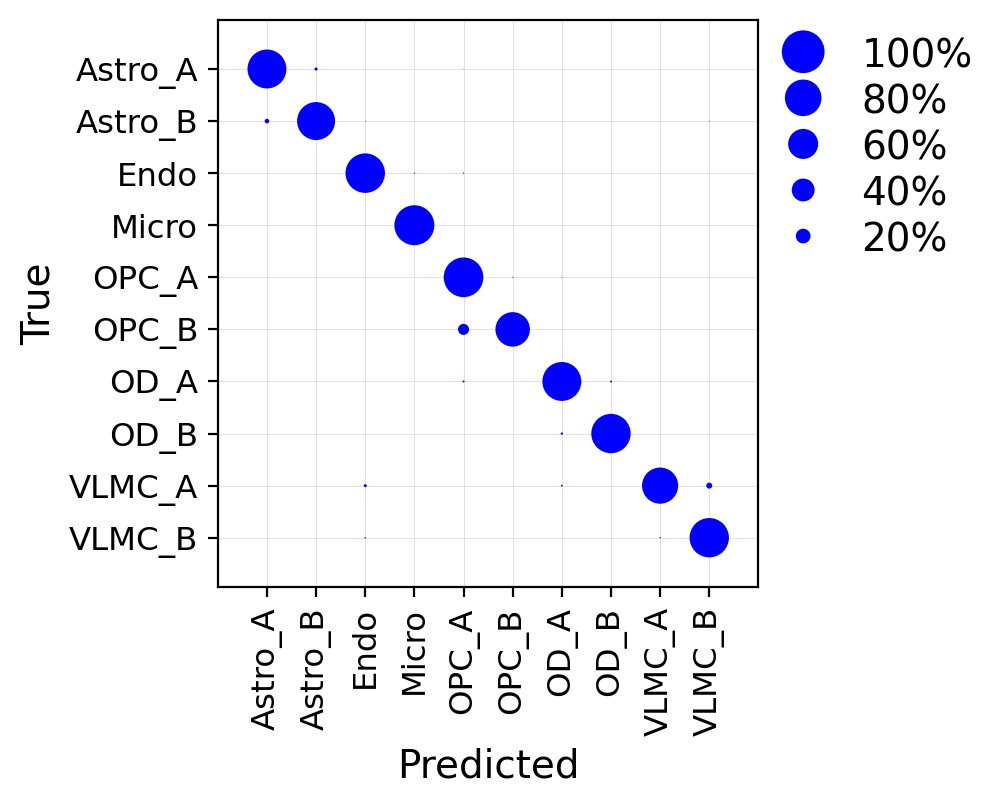

In [ ]:
validationconfmatP8vsP14, validationxticksP8vsP14, validationplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P8vsP14,
    ypred = valid_predlabels_train_70P8vsP14,
    type = 'validation',
    save_as = 'P8_P14Validation_0518.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

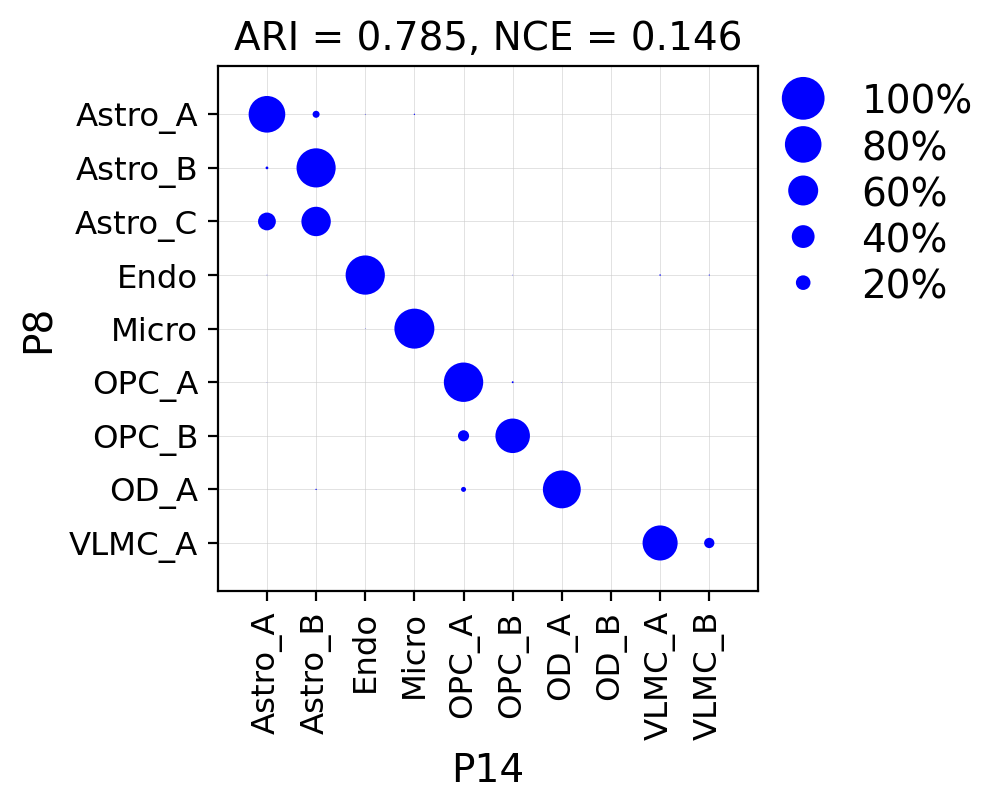

In [ ]:
mappingconfmatP8vsP14, mappingxticksP8vsP14, mappingplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = test_labelsP8vsP14,
    ypred = test_predlabelsP8vsP14,
    type = 'mapping',
    save_as = 'P8_P14Mapping_0518.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14), calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14)),
    xaxislabel = 'P14',
    yaxislabel = 'P8'
    )

In [ ]:
del tm

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P14vsP17, valid_predlabels_train_70P14vsP17, test_labelsP14vsP17, test_predlabelsP14vsP17 = tm.xgbclassifier(
    train_anndata = P17_adata,
    test_anndata = P14_adata,
    train_dict = P17_dict,
    test_dict = P14_dict
    )

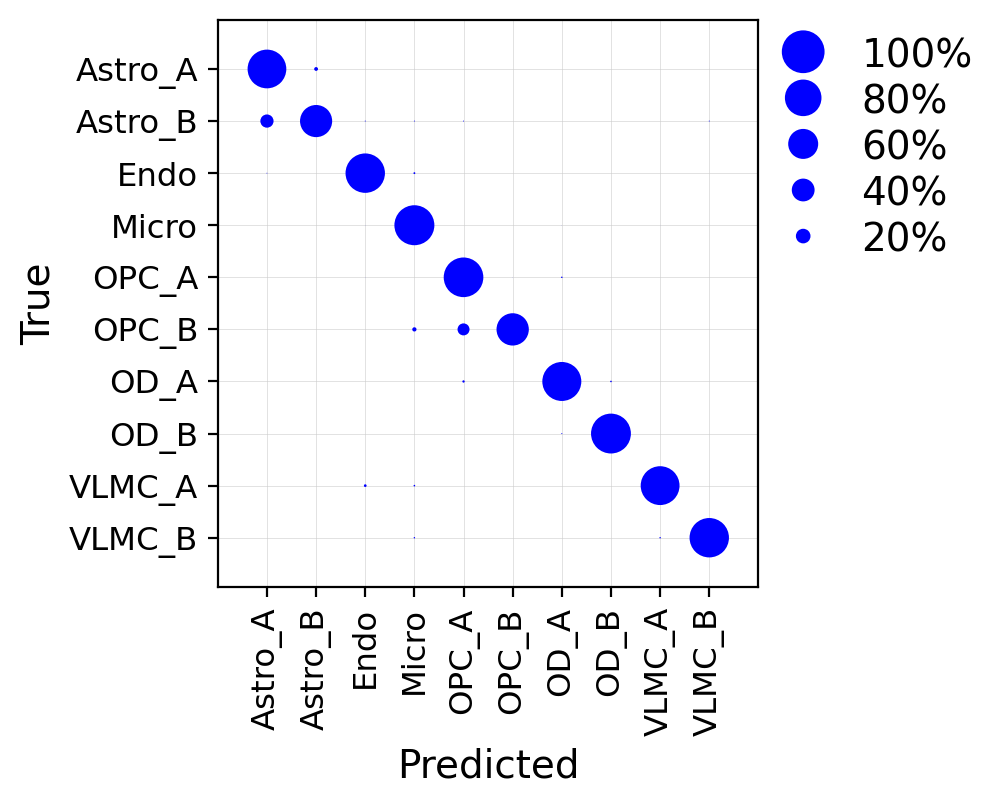

In [ ]:
validationconfmatP14vsP17, validationxticksP14vsP17, validationplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P14vsP17,
    ypred = valid_predlabels_train_70P14vsP17,
    type = 'validation',
    save_as = 'P14_P17Validation_0518.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

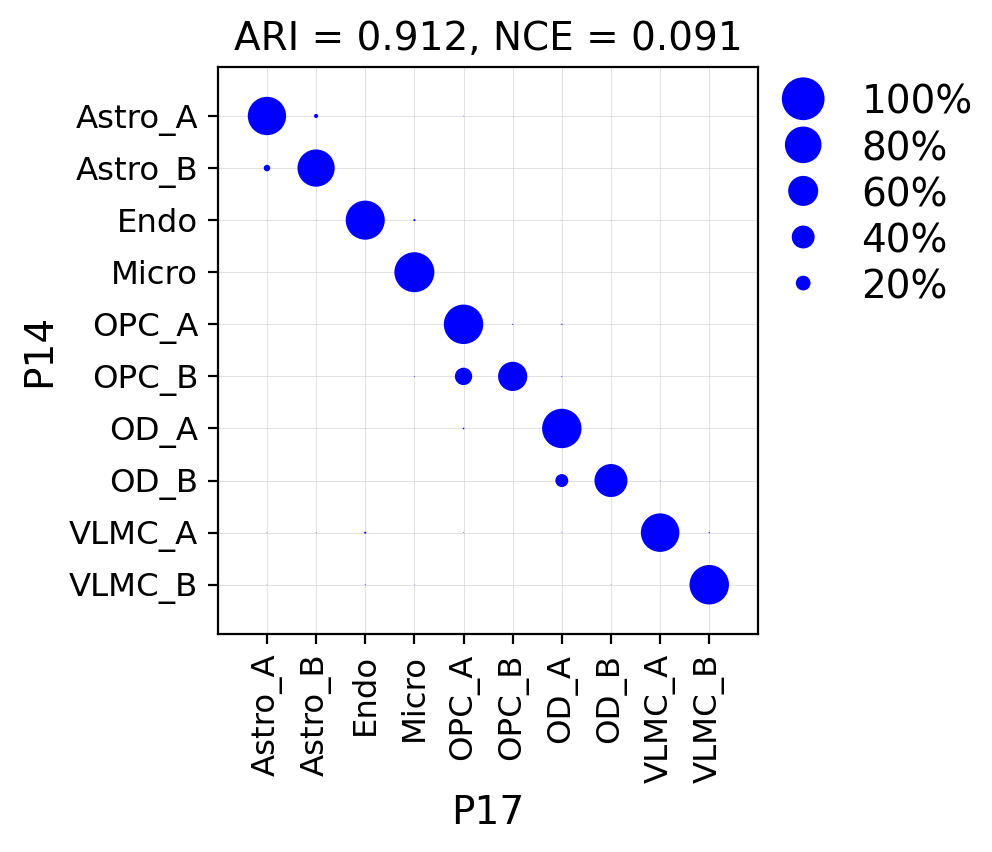

In [ ]:
mappingconfmatP14vsP17, mappingxticksP14vsP17, mappingplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = test_labelsP14vsP17,
    ypred = test_predlabelsP14vsP17,
    type = 'mapping',
    save_as = 'P14_P17Mapping_0518.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17), calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17)),
    xaxislabel = 'P17',
    yaxislabel = 'P14'
    )

In [ ]:
del tm

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P17vsP21, valid_predlabels_train_70P17vsP21, test_labelsP17vsP21, test_predlabelsP17vsP21 = tm.xgbclassifier(
    train_anndata = P21_adata,
    test_anndata = P17_adata,
    train_dict = P21_dict,
    test_dict = P17_dict
    )

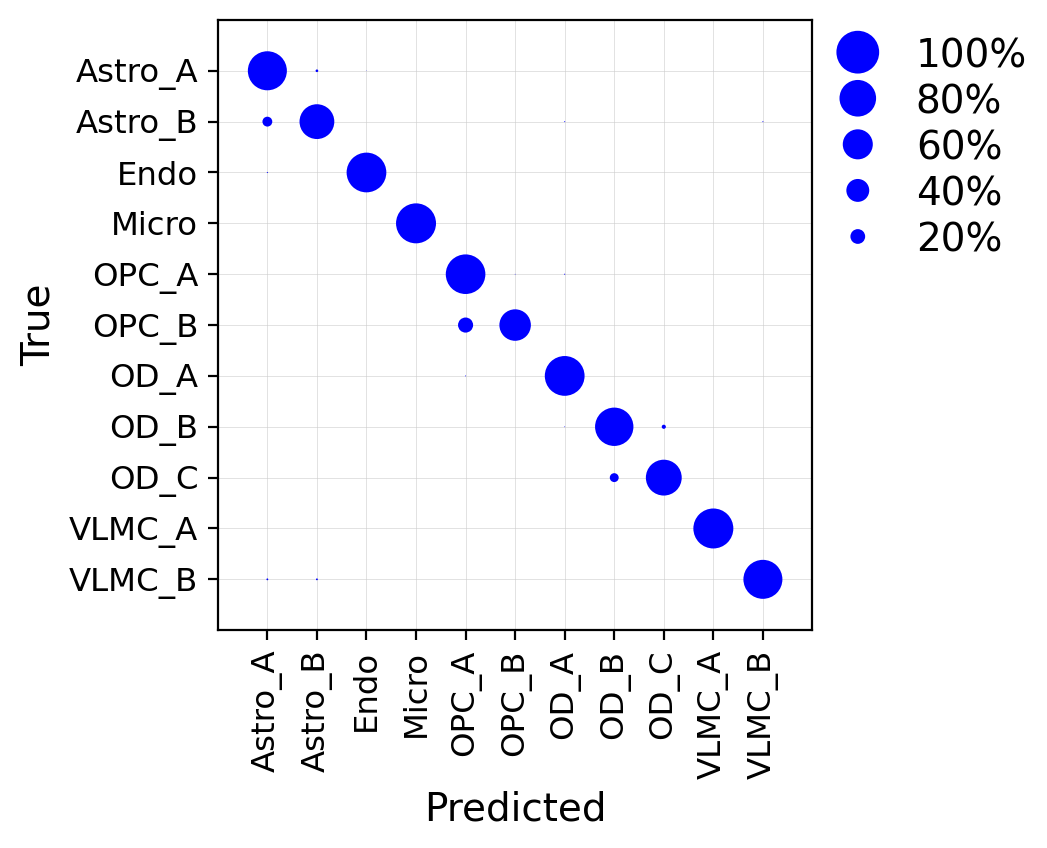

In [ ]:
validationconfmatP17vsP21, validationxticksP17vsP21, validationplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P17vsP21,
    ypred = valid_predlabels_train_70P17vsP21,
    type = 'validation',
    save_as = 'P17_P21Validation_0518.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

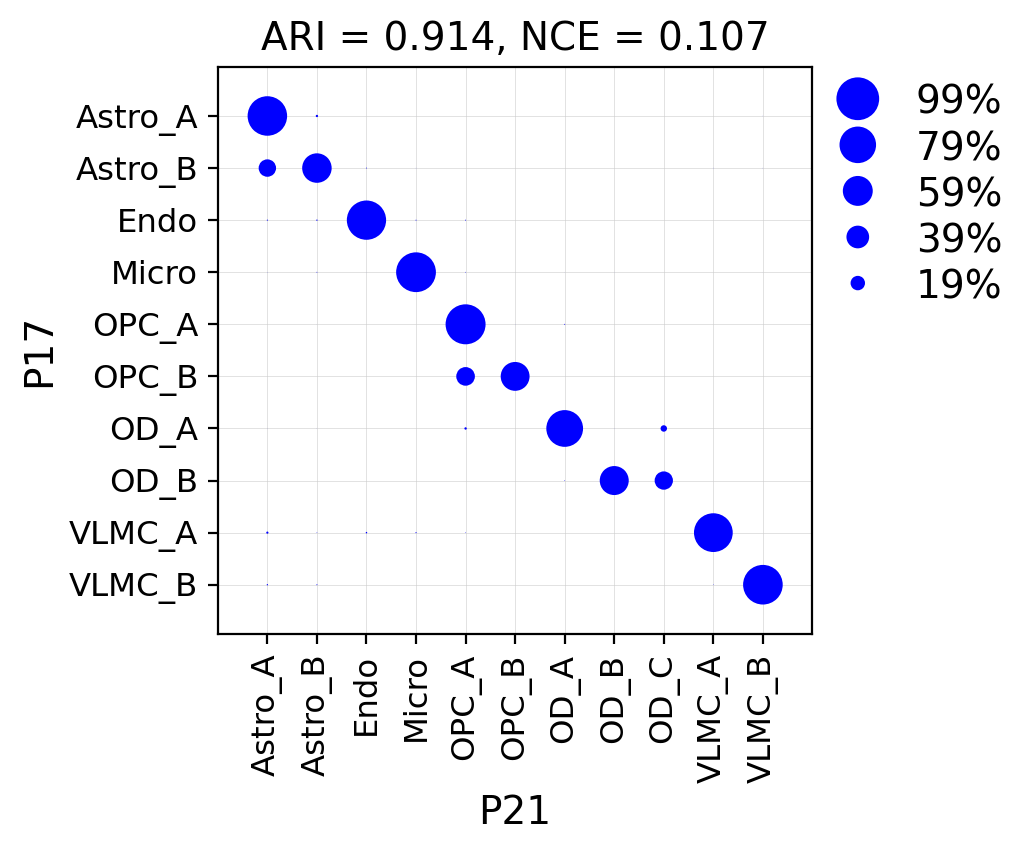

In [ ]:
mappingconfmatP17vsP21, mappingxticksP17vsP21, mappingplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = test_labelsP17vsP21,
    ypred = test_predlabelsP17vsP21,
    type = 'mapping',
    save_as = 'P17_P21Mapping_0518.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21), calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21)),
    xaxislabel = 'P21',
    yaxislabel = 'P17'
    )

In [ ]:
del tm

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P21vsP28, valid_predlabels_train_70P21vsP28, test_labelsP21vsP28, test_predlabelsP21vsP28 = tm.xgbclassifier(
    train_anndata = P28_adata,
    test_anndata = P21_adata,
    train_dict = P28_dict,
    test_dict = P21_dict
    )

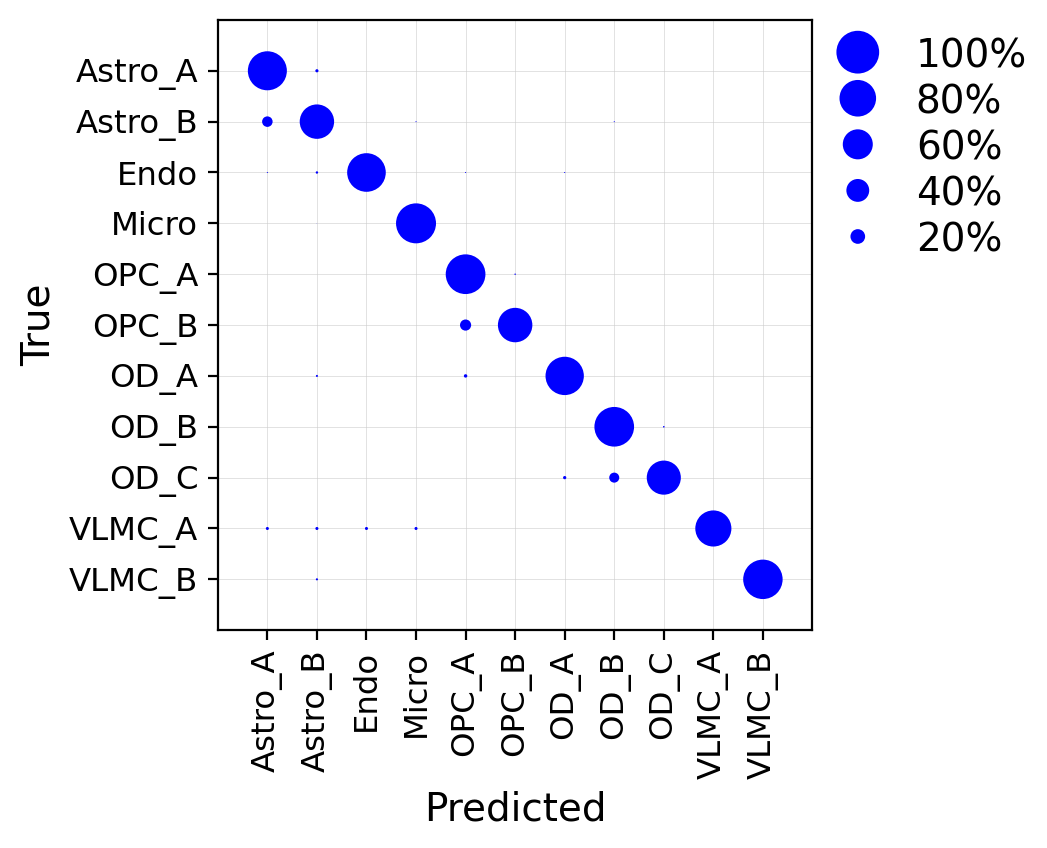

In [ ]:
validationconfmatP21vsP28, validationxticksP21vsP28, validationplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P21vsP28,
    ypred = valid_predlabels_train_70P21vsP28,
    type = 'validation',
    save_as = 'P21_P28Validation_0518.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

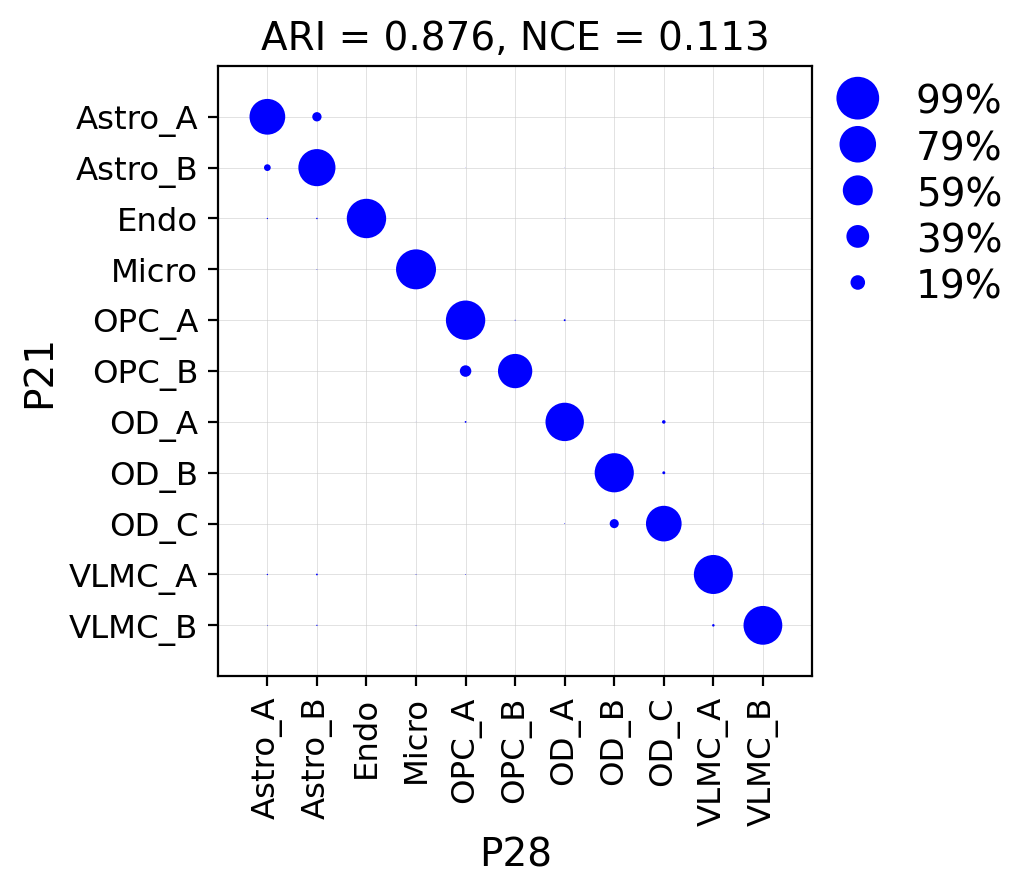

In [ ]:
mappingconfmatP21vsP28, mappingxticksP21vsP28, mappingplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = test_labelsP21vsP28,
    ypred = test_predlabelsP21vsP28,
    type = 'mapping',
    save_as = 'P21_P28Mapping_0518.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28), calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28)),
    xaxislabel = 'P28',
    yaxislabel = 'P21'
    )

In [ ]:
del tm

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P28vsP38, valid_predlabels_train_70P28vsP38, test_labelsP28vsP38, test_predlabelsP28vsP38 = tm.xgbclassifier(
    train_anndata = P38_adata,
    test_anndata = P28_adata,
    train_dict = P38_dict,
    test_dict = P28_dict
    )

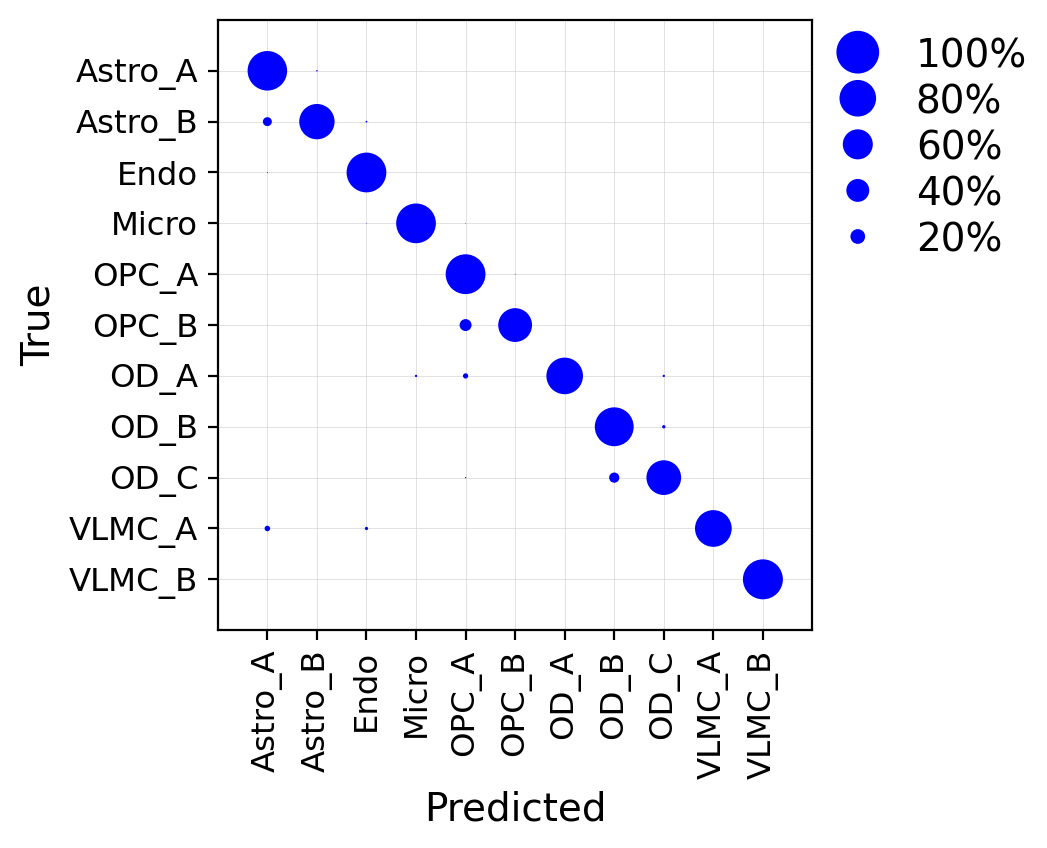

In [ ]:
validationconfmatP28vsP38, validationxticksP28vsP38, validationplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P28vsP38,
    ypred = valid_predlabels_train_70P28vsP38,
    type = 'validation',
    save_as = 'Mappings/P28_P38Validation_0518.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

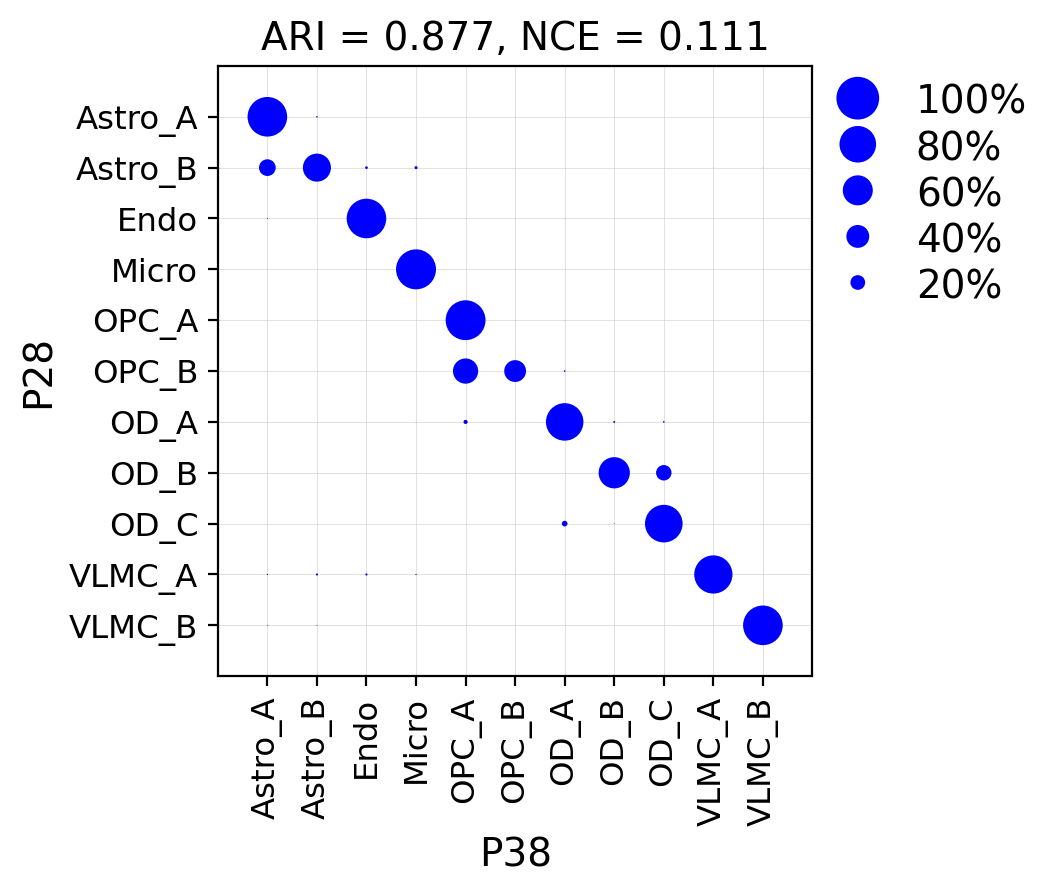

In [ ]:
mappingconfmatP28vsP38, mappingxticksP28vsP38, mappingplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = test_labelsP28vsP38,
    ypred = test_predlabelsP28vsP38,
    type = 'mapping',
    save_as = 'Mappings/P28_P38Mapping_0518.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38), calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38)),
    xaxislabel = 'P38',
    yaxislabel = 'P28'
    )

In [ ]:
del tm

In [ ]:
np.save('SankeymappingconfmatP8vsP14_0518',mappingconfmatP8vsP14)
np.save('SankeymappingconfmatP14vsP17_0518',mappingconfmatP14vsP17)
np.save('SankeymappingconfmatP17vsP21_0518',mappingconfmatP17vsP21)
np.save('SankeymappingconfmatP21vsP28_0518',mappingconfmatP21vsP28)
np.save('SankeymappingconfmatP28vsP38_0518',mappingconfmatP28vsP38)

## Sankey

In [ ]:
mappingconfmatP8vsP14 = np.load('SankeymappingconfmatP8vsP14_0518.npy')
mappingconfmatP14vsP17= np.load('SankeymappingconfmatP14vsP17_0518.npy')
mappingconfmatP17vsP21 = np.load('SankeymappingconfmatP17vsP21_0518.npy')
mappingconfmatP21vsP28 = np.load('SankeymappingconfmatP21vsP28_0518.npy')
mappingconfmatP28vsP38 = np.load('SankeymappingconfmatP28vsP38_0518.npy')

In [ ]:
#Sankey Plot
#Order of the cell types for each age on the Sankey plot
P8_labels = ['Astro_A', 'Astro_B', 'Astro_C', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'VLMC_A']
P14_labels = ['Astro_A', 'Astro_B', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'OD_B', 'VLMC_A', 'VLMC_B']
P17_labels = ['Astro_A', 'Astro_B', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'OD_B', 'VLMC_A', 'VLMC_B']
P21_labels = ['Astro_A', 'Astro_B', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'OD_B', 'OD_C', 'VLMC_A', 'VLMC_B']
P28_labels = ['Astro_A', 'Astro_B', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'OD_B', 'OD_C', 'VLMC_A', 'VLMC_B']
P38_labels = ['Astro_A', 'Astro_B', 'Endo', 'Micro', 'OPC_A', 'OPC_B', 'OD_A', 'OD_B', 'OD_C', 'VLMC_A', 'VLMC_B']

In [ ]:
P8P14confmat = mappingconfmatP8vsP14.T
P14P17confmat = mappingconfmatP14vsP17.T
P17P21confmat = mappingconfmatP17vsP21.T
P21P28confmat = mappingconfmatP21vsP28.T
P28P38confmat = mappingconfmatP28vsP38.T

In [ ]:
sources = []
targets = []
values = []
lst = list(np.linspace(0,len(P8_labels)-1,len(P8_labels)))
sources.extend(list(islice(cycle(lst), len(P8_labels)*len(P14_labels))))
targets.extend(list(np.repeat(np.linspace(0,len(P14_labels)-1,len(P14_labels)), len(P8_labels)) + len(P8_labels)))
values.extend(list(P8P14confmat.flatten()))
lst = list(np.linspace(0,len(P14_labels)-1,len(P14_labels)) + len(P8_labels))
sources.extend(list(islice(cycle(lst), len(P14_labels)*len(P17_labels))))
targets.extend(list(np.repeat(np.linspace(0,len(P17_labels)-1,len(P17_labels)), len(P14_labels)) + len(P8_labels) + len(P14_labels)))
values.extend(list(P14P17confmat.flatten()))
lst = list(np.linspace(0,len(P17_labels)-1,len(P17_labels)) + len(P8_labels) + len(P14_labels))
sources.extend(list(islice(cycle(lst), len(P17_labels)*len(P21_labels))))
targets.extend(list(np.repeat(np.linspace(0,len(P21_labels)-1,len(P21_labels)), len(P17_labels)) + len(P8_labels) + len(P14_labels)+ len(P17_labels)))
values.extend(list(P17P21confmat.flatten()))
lst = list(np.linspace(0,len(P21_labels)-1,len(P21_labels)) + len(P8_labels) + len(P14_labels) + len(P17_labels))
sources.extend(list(islice(cycle(lst), len(P21_labels)*len(P28_labels))))
targets.extend(list(np.repeat(np.linspace(0,len(P28_labels)-1,len(P28_labels)), len(P21_labels)) + len(P8_labels) + len(P14_labels)+ len(P17_labels) + len(P21_labels)))
values.extend(list(P21P28confmat.flatten()))
lst = list(np.linspace(0,len(P28_labels)-1,len(P28_labels)) + len(P8_labels) + len(P14_labels) + len(P17_labels) + len(P21_labels))
sources.extend(list(islice(cycle(lst), len(P28_labels)*len(P38_labels))))
targets.extend(list(np.repeat(np.linspace(0,len(P38_labels)-1,len(P38_labels)), len(P28_labels)) + len(P8_labels) + len(P14_labels)+ len(P17_labels) + len(P21_labels) + len(P28_labels)))
values.extend(list(P28P38confmat.flatten()))

In [ ]:
P8_x = list(np.repeat(0.01,len(P8_labels)))
P8_y = list(np.linspace(0.03,1.17,len(P8_labels)))
P14_x = list(np.repeat(0.01 + 0.1,len(P14_labels)))
P14_y = list(np.linspace(0.02, 1.18,len(P14_labels)))
P17_x = list(np.repeat(0.01 + (2*0.1),len(P17_labels)))
P17_y = list(np.linspace(0.02, 1.18,len(P17_labels)))
P21_x = list(np.repeat(0.01 + (3*0.1),len(P21_labels)))
P21_y = list(np.linspace(0.01, 1.2,len(P21_labels)))
P28_x = list(np.repeat(0.01 + (4*0.1),len(P28_labels)))
P28_y = list(np.linspace(0.01, 1.2,len(P28_labels)))
P38_x = list(np.repeat(0.01 + (5*0.1),len(P38_labels)))
P38_y = list(np.linspace(0.01, 1.2,len(P38_labels)))

In [ ]:
linecolor = []
for i in values:
  if i > 0.8:
    linecolor.append('rgba(0.0, 0.0, 1.0, 0.75)')
  elif 0.5 < i <= 0.8:
    linecolor.append('rgba(0.5411764705882353, 0.16862745098039217, 0.8862745098039215, 0.55)')
  elif 0.2 < i <= 0.5:
    linecolor.append('rgba(0.4392156862745098, 0.5019607843137255, 0.5647058823529412, 0.35)')
  else:
    linecolor.append('rgba(0.6862745098039216, 0.9333333333333333, 0.9333333333333333, 0.25)')

In [ ]:
Astrocytes_color = '#a1c9f4'
Endothelial_color = '#ffb482'
Microglia_color = '#8de5a1'
OPC_color = '#d0bbff'
Oligo_color = '#ff9f9b'
VLMC_color = '#debb9b'

In [ ]:
P8_colors = [Astrocytes_color, Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, VLMC_color]
P14_colors = [Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, Oligo_color, VLMC_color, VLMC_color]
P17_colors = [Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, Oligo_color, VLMC_color, VLMC_color]
P21_colors = [Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, Oligo_color, Oligo_color, VLMC_color, VLMC_color]
P28_colors = [Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, Oligo_color, Oligo_color, VLMC_color, VLMC_color]
P38_colors = [Astrocytes_color, Astrocytes_color, Endothelial_color, Microglia_color, OPC_color, OPC_color, Oligo_color, Oligo_color, Oligo_color, VLMC_color, VLMC_color]

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 30,
      line = dict(color = "black", width = 0.75),
      #label = P8_labels + P14_labels + P17_labels + P21_labels + P28_labels + P38_labels,
      color = P8_colors + P14_colors + P17_colors + P21_colors + P28_colors + P38_colors,
      x = P8_x + P14_x + P17_x + P21_x + P28_x + P38_x,
      y = P8_y + P14_y + P17_y + P21_y + P28_y + P38_y
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
      color = linecolor
  ), textfont = dict(size = 16)
  )])

fig.layout.font.family = 'Arial'

fig.update_layout(
    autosize=False,
    width=1500,
    height=500
)
fig.show()

In [ ]:
fig.write_image('Mappings/Sankey/Sankey_Type_0518.pdf', width = 1000, height = 500, scale = 5)

# F1 Analysis

In [ ]:
def xgbtrain(
    train_anndata,
    train_dict,
    max_cells_per_ident = 700,
    train_frac = 0.7
    ):

    numbertrainclasses = len(train_anndata.obs.Type.values.categories)

    training_set_train = []
    training_label_train = []

    for i in train_anndata.obs.Type.values.categories.values:
        cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
        n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
        train_temp = np.random.choice(cells_in_clust,n,replace = False)
        if len(train_temp) < 100:
            train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
            train_temp = np.hstack([train_temp_bootstrap, train_temp])
        training_set_train = np.hstack([training_set_train,train_temp])
        training_label_train = np.hstack([training_label_train,np.repeat(train_dict[i],len(train_temp))])
        
    train_index_train = []
    for i in training_set_train:
        train_index_train.append(np.where(train_anndata.obs.index.values == i)[0][0])
    
    train_matrix_train = xgb.DMatrix(data = train_anndata.raw.X.A[train_index_train,:], label = training_label_train, feature_names = train_anndata.var.index.values)

    xgb_params_train = {
        'objective':'multi:softprob',
        'eval_metric':'mlogloss',
        'num_class': numbertrainclasses,
        'eta':0.2,
        'max_depth':6,
        'subsample': 0.6}
    nround = 200

    bst_model_train = xgb.train(
        params = xgb_params_train,
        dtrain = train_matrix_train,
        num_boost_round = nround)

    train_xgboost_scores = bst_model_train.get_score(importance_type="gain")
    sort_train_scores = {k: v for k, v in sorted(train_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
    top500genestrain = list(sort_train_scores.keys())

    common_top_genes = np.array(top500genestrain)

    common_top_genes_index_train = []
    for i in common_top_genes:
        common_top_genes_index_train.append(np.where(train_anndata.var.index.values == i)[0][0])

    training_set_train_70 = []
    validation_set_train_70 = []
    training_label_train_70 = []
    validation_label_train_70 = []

    for i in train_anndata.obs.Type.values.categories.values:
        cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
        n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
        train_temp = np.random.choice(cells_in_clust,n,replace = False)
        validation_temp = np.setdiff1d(cells_in_clust, train_temp)
        if len(train_temp) < 100:
            train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
            train_temp = np.hstack([train_temp_bootstrap, train_temp])
        training_set_train_70 = np.hstack([training_set_train_70,train_temp])
        validation_set_train_70 = np.hstack([validation_set_train_70,validation_temp])
        training_label_train_70 = np.hstack([training_label_train_70,np.repeat(train_dict[i],len(train_temp))])
        validation_label_train_70 = np.hstack([validation_label_train_70,np.repeat(train_dict[i],len(validation_temp))])

    train_index_train_70 = []
    for i in training_set_train_70:
        train_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])
    validation_index_train_70 = []
    for i in validation_set_train_70:
        validation_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])

    train_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][train_index_train_70,:], label = training_label_train_70)
    validation_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][validation_index_train_70,:], label = validation_label_train_70)

    del training_set_train_70, validation_set_train_70, training_label_train_70, train_index_train_70, validation_index_train_70

    bst_model_train_70 = xgb.train(
        params = xgb_params_train,
        dtrain = train_matrix_train_70,
        num_boost_round = nround)

    validation_pred_train_70 = bst_model_train_70.predict(data = validation_matrix_train_70)

    valid_predlabels_train_70 = np.zeros((validation_pred_train_70.shape[0]))
    for i in range(validation_pred_train_70.shape[0]):
        valid_predlabels_train_70[i] = np.argmax(validation_pred_train_70[i,:])
    
    f1 = f1_score(validation_label_train_70, valid_predlabels_train_70, average = None)

    return validation_label_train_70, valid_predlabels_train_70, f1

In [ ]:
validation_label_train_70P8, valid_predlabels_train_70P8, f1P8 = xgbtrain(
    train_anndata = P8_adata,
    train_dict = P8_dict
    )

In [ ]:
np.save('f1P8_0602',f1P8)

In [ ]:
Astro_f1 = []
Endo_f1 = []
Micro_f1 = []
OPC_f1 = []
OD_f1 = []
VLMC_f1 = []
P8_Astro_f1 = np.mean(f1P8[0:3])
P8_Endo_f1 = np.mean(f1P8[3])
P8_Micro_f1 = np.mean(f1P8[4])
P8_OPC_f1 = np.mean(f1P8[5:7])
P8_OD_f1 = np.mean(f1P8[7])
P8_VLMC_f1 = np.mean(f1P8[8])
Astro_f1.append(P8_Astro_f1)
Endo_f1.append(P8_Endo_f1)
Micro_f1.append(P8_Micro_f1)
OPC_f1.append(P8_OPC_f1)
OD_f1.append(P8_OD_f1)
VLMC_f1.append(P8_VLMC_f1)

In [ ]:
validation_label_train_70P14, valid_predlabels_train_70P14, f1P14 = xgbtrain(
    train_anndata = P14_adata,
    train_dict = P14_dict
    )

In [ ]:
np.save('f1P14_0602',f1P14)

In [ ]:
P14_Astro_f1 = np.mean(f1P14[0:2])
P14_Endo_f1 = np.mean(f1P14[2])
P14_Micro_f1 = np.mean(f1P14[3])
P14_OPC_f1 = np.mean(f1P14[4:6])
P14_OD_f1 = np.mean(f1P14[6:8])
P14_VLMC_f1 = np.mean(f1P14[8:])
Astro_f1.append(P14_Astro_f1)
Endo_f1.append(P14_Endo_f1)
Micro_f1.append(P14_Micro_f1)
OPC_f1.append(P14_OPC_f1)
OD_f1.append(P14_OD_f1)
VLMC_f1.append(P14_VLMC_f1)

In [ ]:
validation_label_train_70P17, valid_predlabels_train_70P17, f1P17 = xgbtrain(
    train_anndata = P17_adata,
    train_dict = P17_dict
    )

In [ ]:
np.save('f1P17_0602',f1P17)

In [ ]:
P17_Astro_f1 = np.mean(f1P17[0:2])
P17_Endo_f1 = np.mean(f1P17[2])
P17_Micro_f1 = np.mean(f1P17[3])
P17_OPC_f1 = np.mean(f1P17[4:6])
P17_OD_f1 = np.mean(f1P17[6:8])
P17_VLMC_f1 = np.mean(f1P17[8:])
Astro_f1.append(P17_Astro_f1)
Endo_f1.append(P17_Endo_f1)
Micro_f1.append(P17_Micro_f1)
OPC_f1.append(P17_OPC_f1)
OD_f1.append(P17_OD_f1)
VLMC_f1.append(P17_VLMC_f1)

In [ ]:
validation_label_train_70P21, valid_predlabels_train_70P21, f1P21 = xgbtrain(
    train_anndata = P21_adata,
    train_dict = P21_dict
    )

In [ ]:
np.save('f1P21_0602',f1P21)

In [ ]:
P21_Astro_f1 = np.mean(f1P21[0:2])
P21_Endo_f1 = np.mean(f1P21[2])
P21_Micro_f1 = np.mean(f1P21[3])
P21_OPC_f1 = np.mean(f1P21[4:6])
P21_OD_f1 = np.mean(f1P21[6:9])
P21_VLMC_f1 = np.mean(f1P21[9:])
Astro_f1.append(P21_Astro_f1)
Endo_f1.append(P21_Endo_f1)
Micro_f1.append(P21_Micro_f1)
OPC_f1.append(P21_OPC_f1)
OD_f1.append(P21_OD_f1)
VLMC_f1.append(P21_VLMC_f1)

In [ ]:
validation_label_train_70P28, valid_predlabels_train_70P28, f1P28 = xgbtrain(
    train_anndata = P28_adata,
    train_dict = P28_dict
    )

In [ ]:
np.save('f1P28_0602',f1P28)

In [ ]:
P28_Astro_f1 = np.mean(f1P28[0:2])
P28_Endo_f1 = np.mean(f1P28[2])
P28_Micro_f1 = np.mean(f1P28[3])
P28_OPC_f1 = np.mean(f1P28[4:6])
P28_OD_f1 = np.mean(f1P28[6:9])
P28_VLMC_f1 = np.mean(f1P28[9:])
Astro_f1.append(P28_Astro_f1)
Endo_f1.append(P28_Endo_f1)
Micro_f1.append(P28_Micro_f1)
OPC_f1.append(P28_OPC_f1)
OD_f1.append(P28_OD_f1)
VLMC_f1.append(P28_VLMC_f1)

In [ ]:
validation_label_train_70P38, valid_predlabels_train_70P38, f1P38 = xgbtrain(
    train_anndata = P38_adata,
    train_dict = P38_dict
    )

In [ ]:
np.save('f1P38_0602',f1P8)

In [ ]:
P38_Astro_f1 = np.mean(f1P38[0:2])
P38_Endo_f1 = np.mean(f1P38[2])
P38_Micro_f1 = np.mean(f1P38[3])
P38_OPC_f1 = np.mean(f1P38[4:6])
P38_OD_f1 = np.mean(f1P38[6:9])
P38_VLMC_f1 = np.mean(f1P38[9:])
Astro_f1.append(P38_Astro_f1)
Endo_f1.append(P38_Endo_f1)
Micro_f1.append(P38_Micro_f1)
OPC_f1.append(P38_OPC_f1)
OD_f1.append(P38_OD_f1)
VLMC_f1.append(P38_VLMC_f1)

In [ ]:
np.save('Astro_f1_0602',Astro_f1)
np.save('Endo_f1_0602',Endo_f1)
np.save('Micro_f1_0602',Micro_f1)
np.save('OPC_f1_0602',OPC_f1)
np.save('OD_f1_0602',OD_f1)
np.save('VLMC_f1_0602',VLMC_f1)

In [ ]:
Astro_f1 = np.load('Astro_f1_0602'+'.npy')
Endo_f1 = np.load('Endo_f1_0602'+'.npy')
Micro_f1 = np.load('Micro_f1_0602'+'.npy')
OPC_f1 = np.load('OPC_f1_0602'+'.npy')
OD_f1 = np.load('OD_f1_0602'+'.npy')
VLMC_f1 = np.load('VLMC_f1_0602'+'.npy')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


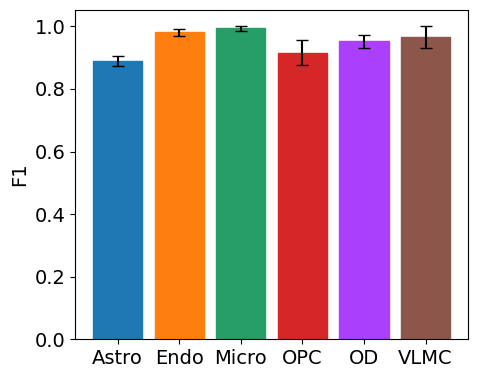

In [ ]:
#Add code for plotting the average f1 score for each subclass as a function of the time point
fig, axes = plt.subplots(1,1, figsize = (5,4))
timepair = [0,1,2,3,4,5]
axes.set_ylabel('F1')
fl_mean = [np.mean(Astro_f1), np.mean(Endo_f1), np.mean(Micro_f1), np.mean(OPC_f1), np.mean(OD_f1), np.mean(VLMC_f1)]
fl_std = [np.std(Astro_f1), np.std(Endo_f1), np.std(Micro_f1), np.std(OPC_f1), np.std(OD_f1), np.std(VLMC_f1)]
barplot = axes.bar(timepair, fl_mean, yerr = fl_std, capsize = 4)
barplot[0].set_color('C0')
barplot[1].set_color('C1')
barplot[2].set_color('C2')
barplot[3].set_color('C3')
barplot[4].set_color('C4')
barplot[5].set_color('C5')
axes.set_ylim(bottom = 0)
axes.set_xticks(timepair)
axes.set_xticklabels(['Astro', 'Endo', 'Micro', 'OPC', 'OD', 'VLMC'], rotation=0)
axes.tick_params(axis='both', labelsize='medium')
axes.grid(False)
fig.tight_layout()
fig.savefig('Barplot_GlutClusterLearnability-F1_0602.pdf')

In [ ]:
Astro_Micro_t, Astro_Micro_p = sp.stats.ttest_ind(a = Astro_f1, b = Micro_f1)
Endo_Micro_t, Endo_Micro_p = sp.stats.ttest_ind(a = Endo_f1, b = Micro_f1)
OPC_Micro_t, OPC_Micro_p = sp.stats.ttest_ind(a = OPC_f1, b = Micro_f1)
OD_Micro_t, OD_Micro_p = sp.stats.ttest_ind(a = OD_f1, b = Micro_f1)
VLMC_Micro_t, VLMC_Micro_p = sp.stats.ttest_ind(a = VLMC_f1, b = Micro_f1)

In [ ]:
print(Astro_Micro_p, Endo_Micro_p, OPC_Micro_p, OD_Micro_p, VLMC_Micro_p)

1.2077365419327707e-07 0.055380435550657275 0.0018311879831782029 0.001598738708545824 0.10446722078105974
